/datadisk1/ixk5174/project_repo/Telos-test
test_output/pacbio_ENCFF370NFS_isoquant/features/pacbio_ENCFF370NFS_isoquant_tss_labeled.tsv
df_cov.shape: (29293, 14)
df_label.shape: (29293, 2)
After merging df_tss with df_cov, df.shape: (29293, 95)
Labeling TSS candidates with 50 nt tolerance ...
Labeled 0 candidates
Labeled 10000 candidates
Labeled 20000 candidates
After merging df_label with df, df.shape: (29293, 19)
matched_labels.shape: (16816, 19)
mismatch_labels.shape: (12477, 19)
PR curve data shape: (293, 2)


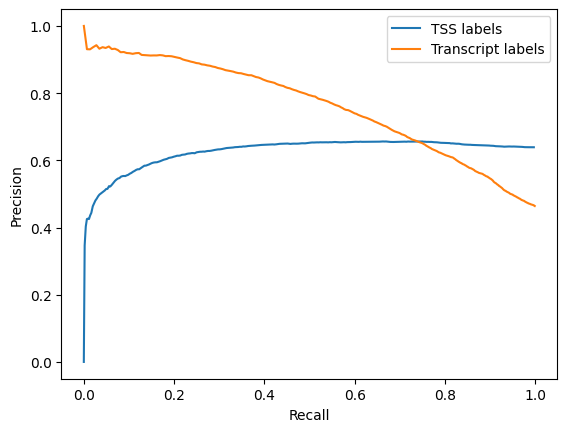

In [ ]:
from extract_features import extract_features
from config import load_config
import pysam
import pandas as pd
from ml_utils import load_tmap_labels
import os
import numpy as np

os.chdir("/datadisk1/ixk5174/project_repo/Telos-test/")
print(os.getcwd())


def load_reference(reference_path):
    """Load reference annotation TSS/TES positions."""
    ref_df = pd.read_csv(reference_path, sep=" ", header=None,
                         names=["site_type", "chrom", "position", "pos_strand_cnt", "neg_strand_cnt"],
                         dtype={"chrom": str})
    ref_df["strand"] = ref_df.apply(
        lambda x: "+" if x["pos_strand_cnt"] > x["neg_strand_cnt"] else "-", axis=1
    )
    ref_df = ref_df[["site_type", "chrom", "position", "strand"]]
    # print(ref_df.head(5))
    return ref_df



def label_candidates(candidate_df, reference_df, site_type, max_distance=50):
    """Fast labeling using grouped and vectorized search."""
    
    reference_df = reference_df[
        reference_df['site_type'].str.lower() == site_type.lower()
    ].copy()
    reference_df['chrom'] = reference_df['chrom'].astype(str)
    reference_df['position'] = reference_df['position'].astype(int)

    # Group reference sites for fast lookup
    grouped_ref = reference_df.groupby(['chrom', 'strand'])

    labels = np.zeros(len(candidate_df), dtype=int)
    closest_ref_positions = np.zeros(len(candidate_df), dtype=int)

    print(f"Labeling {site_type.upper()} candidates with {max_distance} nt tolerance ...")
    for i, row in candidate_df.iterrows():
        chrom, pos, strand = row['chrom'], row['position'], row['strand']
        if i % 10000 == 0:
            print(f"Labeled {i} candidates")
            # sys.stdout.flush()
            
        try:
            group = grouped_ref.get_group((chrom, strand))
        except KeyError:
            continue  # No matching chrom+strand in reference
        
        # Use numpy for fast range check
        ref_positions = group['position'].values
        # find the index of the reference position that is closest to the candidate position
        closest_index = np.argmin(np.abs(ref_positions - pos))
        # get the position of the closest reference position
        closest_ref_positions[i] = ref_positions[closest_index]
        labels[i] = 1 if np.abs(ref_positions[closest_index] - pos) <= max_distance else 0

    candidate_df['label'] = labels
    candidate_df['closest_ref_position'] = closest_ref_positions
    return candidate_df

cfg = load_config("project_config/pacbio_ENCFF370NFS_isoquant_config.pkl")
# bam = pysam.AlignmentFile("../" + cfg.bam_file, "rb")  # <-- adjust path if needed
print(cfg.tss_labeled_file)
df_tss = pd.read_csv(cfg.tss_labeled_file, dtype={"chrom": str})
df_tes = pd.read_csv(cfg.tes_labeled_file, dtype={"chrom": str})

df_cov = pd.read_csv(cfg.cov_file, sep="\t")
print(f"df_cov.shape: {df_cov.shape}")
df_label = load_tmap_labels(cfg.tmap_file)
print(f"df_label.shape: {df_label.shape}")

# print()

df = df_cov.merge(df_tss, left_on=["tss_chrom", "tss_pos"], right_on=["chrom", "position"], how="inner")
print(f"After merging df_tss with df_cov, df.shape: {df.shape}")
# print(df.columns)
selected_cols_min = ["transcript_id", "chrom", "position", "coverage", "strand_x", "label"] 
selected_cols = selected_cols_min.copy()
for col in df_cov.columns:
    if col not in selected_cols_min and col != "strand" and "tes" not in col.lower():
        selected_cols.append(col)
df_min = df[selected_cols_min].copy()
df = df[selected_cols]

df.rename(columns={"strand_x": "strand"}, inplace=True)
ref_df = load_reference(cfg.ref_candidate_file)
df = label_candidates(df, ref_df, "tss", 50)
df_min["label"] = df["label"]
df_min["closest_ref_position"] = df["closest_ref_position"]

# df.to_csv("tmp.tsv", sep="\t")


# df = df.merge(df_tes, left_on=["tes_chrom", "tes_pos"], right_on=["chrom", "position"], how="inner", suffixes=("_tss", "_tes"))
# print(f"After merging df_tes with df, df.shape: {df.shape}")
df = df.merge(df_label, left_on=["transcript_id"], right_on=["transcript_id"], how="inner", suffixes=("_tss", "_tr"))
df_min = df_min.merge(df_label, left_on=["transcript_id"], right_on=["transcript_id"], how="inner", suffixes=("_tss", "_tr"))
print(f"After merging df_label with df, df.shape: {df.shape}")

# print(df.head(30))


# comparison between tss and transcript labels
matched_labels = df[df["label_tss"] == df["label_tr"]]
print(f"matched_labels.shape: {matched_labels.shape}")
mismatch_labels = df[df["label_tss"] != df["label_tr"]]
print(f"mismatch_labels.shape: {mismatch_labels.shape}")

# sort by coverage
sorted_df = df.sort_values(by="coverage", ascending=False)
# change print to display all columns without line breaks
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# print(sorted_df.head(100))
sorted_df.copy().to_csv("tmp.tsv", sep="\t", index=False)
sorted_df_min = sorted_df.copy().drop(columns=["transcript_id"])
sorted_df_min.to_csv("tmp_min.tsv", sep="\t", index=False)


# generate precision and recall for different coverage bins like a pr curve
precisions = []
recalls = []
n_total = len(sorted_df)
n_positive = sorted_df['label_tss'].sum()

for k in range(1, n_total + 1, 100):
    # Keep top k highest coverage points
    subset = sorted_df.iloc[:k]
    n_kept = len(subset)
    n_tp = subset['label_tss'].sum()  # true positives in kept subset
    n_fp = n_kept - n_tp  # false positives in kept subset
    
    # Precision = TP / (TP + FP)
    precision = n_tp / n_kept 
    # Recall = TP / (total positive)  
    recall = n_tp / n_positive 
    
    precisions.append(precision)
    recalls.append(recall)

# Create dataframe with PR curve data
pr_df = pd.DataFrame({
    'precision': precisions,
    'recall': recalls
})
print(f"PR curve data shape: {pr_df.shape}")

# print(pr_df.sort_values(by="recall", ascending=False).head(30))

# generate precision and recall for different coverage bins like a pr curve for transcript labels
precisions = []
recalls = []
n_total = len(sorted_df)
n_positive = sorted_df['label_tr'].sum()

for k in range(1, n_total + 1, 100):
    subset = sorted_df.iloc[:k]
    n_kept = len(subset)
    n_tp = subset['label_tr'].sum()
    n_fp = n_kept - n_tp
    
    precision = n_tp / n_kept
    recall = n_tp / n_positive
    
    precisions.append(precision)
    recalls.append(recall)
    

pr_df_transcript = pd.DataFrame({
    'precision': precisions,
    'recall': recalls
})

# print(pr_df_transcript.head(30))

# generate a pr curve with the two pr curves on the same plot
import matplotlib.pyplot as plt
plt.plot(pr_df['recall'], pr_df['precision'], label='TSS labels')
plt.plot(pr_df_transcript['recall'], pr_df_transcript['precision'], label='Transcript labels')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()









In [6]:
from ml_utils import load_tmap_labels
from config import load_config
import pandas as pd
import os 
import numpy as np
from ml_utils import stratified_split

os.chdir("/datadisk1/ixk5174/project_repo/Telos-test/")
print(os.getcwd())

project_config = load_config("project_config/cDNA-NA12878_stringtie_config.pkl")
pred_df = pd.read_csv(f"{project_config.predictions_output_dir}/randomforest_stage2_predictions_train.csv", sep = "\t")

# find accuracy of model
acc = 0
inc_count = 0
# pred_df['pred_label'] = pred_df['pred_label'].astype(int)
for i in range(len(pred_df)):
    if pred_df.iloc[i]['pred_label'] == pred_df.iloc[i]['label']:
        acc += 1
    else:
        # print(f"pred_df.iloc[i]:  {pred_df.iloc[i]}")
        inc_count += 1
print(f"Accuracy of model: {acc/len(pred_df)}")
print(f"Inc_count: {inc_count}")




/datadisk1/ixk5174/project_repo/Telos-test
Accuracy of model: 0.8783683821198351
Inc_count: 1151
